# Vision Transformer Image Explainability Research
By: Brett Huffman, [www.bretthuffman.com](https://www.bretthuffman.com)

Makes sure you are running GPU versions of Colab for these tests

With code from Aritra Roy Gosthipaty, Sayak Paul (https://github.com/sayakpaul/probing-vits)

In [ ]:
!pip install -U gdown -q

#!pip uninstall tensorflow
#!pip uninstall numpy

#!pip install numpy==1.19.5


In [ ]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [ ]:
RESOLUTION = 224
PATCH_SIZE = 16

In [ ]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image


21675/21675 [==============================] - 0s 0us/step


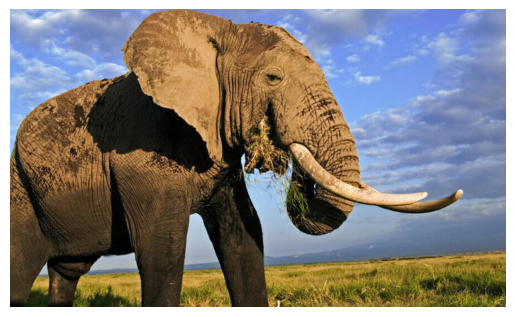

In [ ]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://files.worldwildlife.org/wwfcmsprod/images/African_Elephant_Kenya_112367/story_full_width/qxyqxqjtu_WW187785.jpg"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

## Load a model

In [ ]:
import os
GITHUB_RELEASE = "https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip"
FNAME = "probing_vits.zip"
MODELS_ZIP = {
    "vit_b16_patch16_224": "Probing_ViTs/vit_b16_patch16_224.zip",
    "vit_b16_patch16_224-i1k_pretrained": "Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip",
}

In [ ]:
zip_path = tf.keras.utils.get_file(
    fname=FNAME,
    origin=GITHUB_RELEASE,
)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./")

os.rename("Probing ViTs", "Probing_ViTs")


def load_model(model_path: str) -> tf.keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall("Probing_ViTs/")
    model_name = model_path.split(".")[0]

    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs, training=False)

    return keras.Model(inputs, outputs=[outputs, attention_weights])


vit_base_i21k_patch16_224 = load_model(MODELS_ZIP["vit_b16_patch16_224-i1k_pretrained"])
print("Model loaded.")

1346273766/1346273766 [==============================] - 21s 0us/step
Model loaded.


**More about the model**:

This model was pretrained on the ImageNet-21k dataset and was then fine-tuned on the
ImageNet-1k dataset. To learn more about how we developed this model in TensorFlow
(with pretrained weights from
[this source](https://github.com/google-research/vision_transformer/)).

* [Original ViT model (pretrained on ImageNet-21k)](https://drive.google.com/file/d/1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ/view?usp=sharing)
* [Original ViT model (pretrained on ImageNet-1k)](https://drive.google.com/file/d/1ApOdYe4NXxhPhJABefgZ3KVvqsQzhCL7/view?usp=sharing)

## Running regular inference with the model


In [ ]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

1/1 [==============================] - 3s 3s/step
African_elephant, Loxodonta_africana


##Attention heatmaps

In [ ]:

# Preprocess the same image but with normlization.
#img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

# Grab the predictions.
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

1/1 [==============================] - 1s 1s/step


A Transformer block consists of multiple heads. Each head in a Transformer block projects
the input data to different sub-spaces. This helps each individual head to attend to
different parts of the image. Therefore, it makes sense to visualize each attention head
map seperately, to make sense of what each heads looks at.

**Notes**:

* The following code has been copy-modified from the
[original DINO codebase](https://github.com/facebookresearch/dino/blob/main/visualize_attention.py).
* Here we grab the attention maps of the last Transformer block.
* [DINO](https://arxiv.org/abs/2104.14294) was pretrained using a self-supervised
objective.

In [ ]:

def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    num_heads = attention_scores.shape[1]  # Number of attention heads

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions


We can use the same image we used for inference with DINO and the `attention_score_dict`
we extracted from the results.

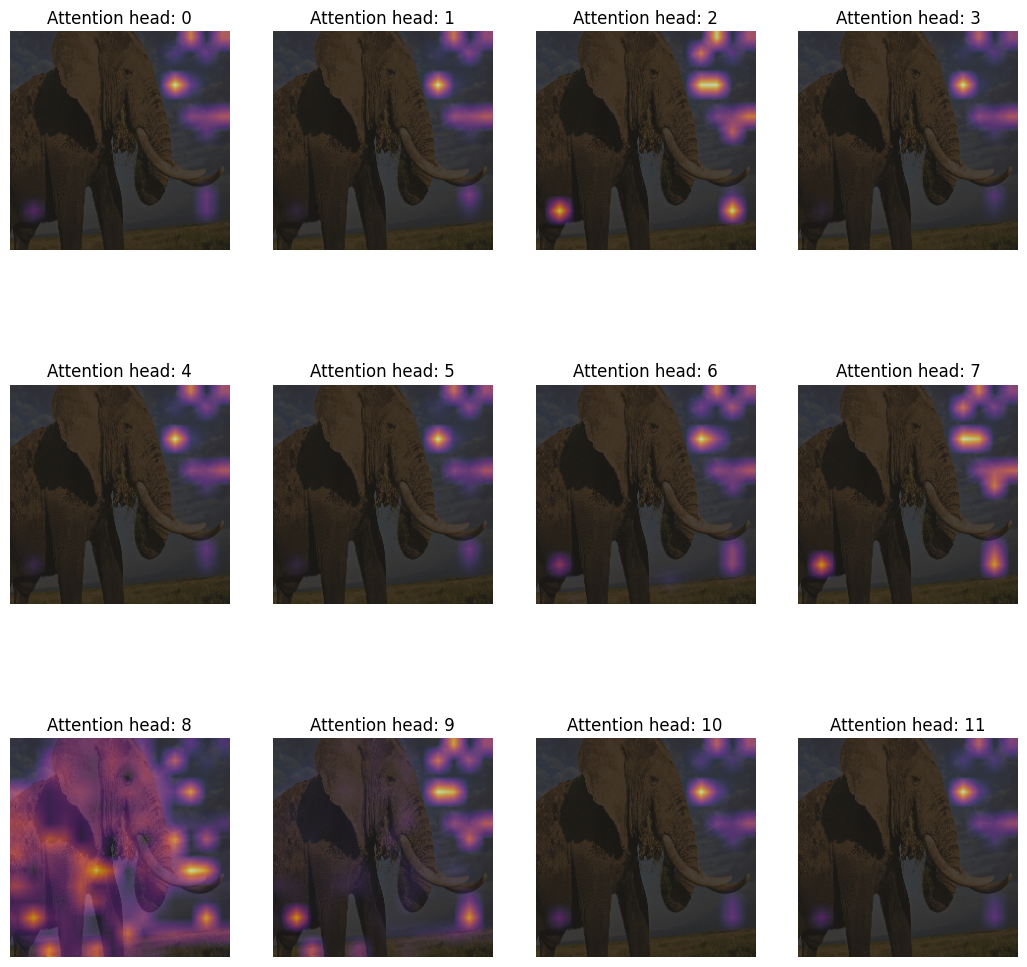

In [ ]:
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

## Acknowledgements

- [Probing ViTs] (https://github.com/sayakpaul/probing-vits)
- [PyImageSearch](https://pyimagesearch.com)
- [Jarvislabs.ai](https://jarvislabs.ai/)
- [GDE Program](https://developers.google.com/programs/experts/)
